##Sentiment Analysis on a dataset of tweets

Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
df=pd.read_csv("clean_tweet_Dec19ToDec20.csv")

In [ ]:
df.head()

,Unnamed: 0,text,sentiment
0,0,text,0
1,1,rising cases of covid does not alarm me rising...,1
2,2,please vote for chicagoindiaresolution marking...,0
3,3,wishing all of you eidaladha hazrat ibrahim as...,1
4,4,daily coronavirus cases in india top for first...,1


In [ ]:
df.shape

(134348, 3)

In [ ]:
df = df.drop([560,
 889,
 7460,
 8219,
 8871,
 8980,
 9018,
 9406,
 9439,
 9510,
 39232,
 62196,
 70127,
 70975,
 71027,
 71197,
 83400,
 120787])
df.shape

(134330, 3)

In [ ]:
df.isnull().any()

Unnamed: 0    False
text          False
sentiment     False
dtype: bool

Data Splitting

In [ ]:
train_df=df.iloc[:107465]
test_df=df.iloc[107465:]

In [ ]:
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,Unnamed: 0,text,sentiment
57312,57312,when nigga cheat on you it ll make you feel su...,1
9033,9033,in,0
34478,34478,no one notices when you are sad but ya when th...,0
94723,94723,all day ve been grafting to put the pool up an...,1
64005,64005,what is the problem with diaspora sikhs consta...,0


In [ ]:
train_df.sentiment.value_counts()

sentiment
0    54429
1    53036
Name: count, dtype: int64

Text Preprocess

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
    return text

def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
#df['text'] = df['text'].apply(lambda x:clean_text(x))

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words()
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def remove_stopwords_from_sentence(sentence):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(sentence)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)
df['text'] = df['text'].apply(remove_stopwords_from_sentence)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["sentiment"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [ ]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(96718, 96718, 10747, 10747)

In [ ]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

26

Text Vectorization

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization # after TensorFlow 2.6
max_vocab_length = 150000
max_length = 26

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 26), dtype=int64, numpy=
array([[2985,    1, 5058,    7,   13, 1651,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [ ]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 73002
Top 5 most common words: ['', '[UNK]', 'the', 'to', 'and']
Bottom 5 least common words: ['aaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaa']


In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length,
                             name="embedding_1")

embedding

##First model:Naive bayes(Baseline)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")
baseline_preds = model_0.predict(val_sentences)

Our baseline model achieves an accuracy of: 80.75%


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 80.74811575323346,
 'precision': 0.8099384339974407,
 'recall': 0.8074811575323346,
 'f1': 0.8067593728851282}

##Deep Learning models:Simple dense Model

In [ ]:
from helper_functions import create_tensorboard_callback
SAVE_DIR = "model_logs"

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [ ]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 26)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 26, 128)           19200000  
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 19200129 (73.24 MB)
Trainable params: 1

In [ ]:
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20240523-164112
Epoch 1/5
3023/3023 [==============================] - 55s 17ms/step - loss: 0.3868 - accuracy: 0.8368 - val_loss: 0.3100 - val_accuracy: 0.8781
Epoch 2/5
3023/3023 [==============================] - 30s 10ms/step - loss: 0.2516 - accuracy: 0.9051 - val_loss: 0.3099 - val_accuracy: 0.8789
Epoch 3/5
3023/3023 [==============================] - 29s 10ms/step - loss: 0.2128 - accuracy: 0.9220 - val_loss: 0.3297 - val_accuracy: 0.8739
Epoch 4/5
3023/3023 [==============================] - 30s 10ms/step - loss: 0.1900 - accuracy: 0.9325 - val_loss: 0.3537 - val_accuracy: 0.8659
Epoch 5/5
3023/3023 [==============================] - 29s 9ms/step - loss: 0.1734 - accuracy: 0.9393 - val_loss: 0.3750 - val_accuracy: 0.8643


In [ ]:
model_1.evaluate(val_sentences, val_labels)

336/336 [==============================] - 1s 3ms/step - loss: 0.3750 - accuracy: 0.8643


[0.37501487135887146, 0.864334225654602]

In [ ]:
model_1_pred_probs = model_1.predict(val_sentences)

336/336 [==============================] - 1s 2ms/step


In [ ]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

In [ ]:
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 86.4334232809156,
 'precision': 0.8643821614855608,
 'recall': 0.864334232809156,
 'f1': 0.8643462206377419}

##LSTM Model

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 26, 128)
(None, 64)


In [ ]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20240523-164443
Epoch 1/5
3023/3023 [==============================] - 55s 17ms/step - loss: 0.3080 - accuracy: 0.8626 - val_loss: 0.2482 - val_accuracy: 0.9002
Epoch 2/5
3023/3023 [==============================] - 36s 12ms/step - loss: 0.1779 - accuracy: 0.9270 - val_loss: 0.2623 - val_accuracy: 0.8984
Epoch 3/5
3023/3023 [==============================] - 37s 12ms/step - loss: 0.1141 - accuracy: 0.9541 - val_loss: 0.2876 - val_accuracy: 0.8916
Epoch 4/5
3023/3023 [==============================] - 35s 12ms/step - loss: 0.0668 - accuracy: 0.9742 - val_loss: 0.3756 - val_accuracy: 0.8864
Epoch 5/5
3023/3023 [==============================] - 35s 12ms/step - loss: 0.0367 - accuracy: 0.9862 - val_loss: 0.4455 - val_accuracy: 0.8825


In [ ]:
model_2_pred_probs = model_2.predict(val_sentences)

336/336 [==============================] - 2s 3ms/step


In [ ]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))

In [ ]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 88.24788313017586,
 'precision': 0.8824740407076008,
 'recall': 0.8824788313017586,
 'f1': 0.8824670678908941}

## GRU Model

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 26)                0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 26, 128)           19200000  
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19237313 (73.38 MB)
Trainable params: 19237313 (73.38 MB)
Non-trainable params: 0 (0.00 Byte)
_____________

In [ ]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20240523-170626
Epoch 1/5
3023/3023 [==============================] - 55s 17ms/step - loss: 0.3086 - accuracy: 0.8598 - val_loss: 0.2341 - val_accuracy: 0.9045
Epoch 2/5
3023/3023 [==============================] - 37s 12ms/step - loss: 0.1734 - accuracy: 0.9293 - val_loss: 0.2429 - val_accuracy: 0.9018
Epoch 3/5
3023/3023 [==============================] - 35s 12ms/step - loss: 0.1053 - accuracy: 0.9582 - val_loss: 0.2857 - val_accuracy: 0.8873
Epoch 4/5
3023/3023 [==============================] - 36s 12ms/step - loss: 0.0580 - accuracy: 0.9779 - val_loss: 0.4266 - val_accuracy: 0.8856
Epoch 5/5
3023/3023 [==============================] - 37s 12ms/step - loss: 0.0316 - accuracy: 0.9883 - val_loss: 0.5482 - val_accuracy: 0.8757


In [ ]:
model_3_pred_probs = model_3.predict(val_sentences)

336/336 [==============================] - 3s 6ms/step


In [ ]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))

In [ ]:
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 87.56862380199125,
 'precision': 0.8770869246334405,
 'recall': 0.8756862380199125,
 'f1': 0.8754402190677074}

## Biderctional LSTM Model

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [ ]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 26)                0         
 ctorization)                                                    
                                                                 
 embedding_4 (Embedding)     (None, 26, 128)           19200000  
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 19298945 (73.62 MB)
Trainable p

In [ ]:
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20240523-172230
Epoch 1/5
3023/3023 [==============================] - 63s 19ms/step - loss: 0.3023 - accuracy: 0.8646 - val_loss: 0.2252 - val_accuracy: 0.9072
Epoch 2/5
3023/3023 [==============================] - 42s 14ms/step - loss: 0.1725 - accuracy: 0.9286 - val_loss: 0.2478 - val_accuracy: 0.8978
Epoch 3/5
3023/3023 [==============================] - 43s 14ms/step - loss: 0.1026 - accuracy: 0.9584 - val_loss: 0.3060 - val_accuracy: 0.8893
Epoch 4/5
3023/3023 [==============================] - 42s 14ms/step - loss: 0.0538 - accuracy: 0.9793 - val_loss: 0.4007 - val_accuracy: 0.8853
Epoch 5/5
3023/3023 [==============================] - 42s 14ms/step - loss: 0.0255 - accuracy: 0.9906 - val_loss: 0.5287 - val_accuracy: 0.8821


In [ ]:
model_4_pred_probs = model_4.predict(val_sentences)

336/336 [==============================] - 3s 6ms/step


In [ ]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))

In [ ]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 88.21066344096027,
 'precision': 0.882192634431203,
 'recall': 0.8821066344096027,
 'f1': 0.8821212113541769}

## Convolutional Neural Network (Conv1D)

In [ ]:
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 26, 128]), TensorShape([1, 22, 32]), TensorShape([1, 32]))

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [ ]:
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 26)                0         
 ctorization)                                                    
                                                                 
 embedding_5 (Embedding)     (None, 26, 128)           19200000  
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [ ]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20240523-174731
Epoch 1/5
3023/3023 [==============================] - 72s 22ms/step - loss: 0.3234 - accuracy: 0.8607 - val_loss: 0.2673 - val_accuracy: 0.8903
Epoch 2/5
3023/3023 [==============================] - 45s 15ms/step - loss: 0.1854 - accuracy: 0.9267 - val_loss: 0.2719 - val_accuracy: 0.8886
Epoch 3/5
3023/3023 [==============================] - 42s 14ms/step - loss: 0.0865 - accuracy: 0.9698 - val_loss: 0.3475 - val_accuracy: 0.8711
Epoch 4/5
3023/3023 [==============================] - 45s 15ms/step - loss: 0.0359 - accuracy: 0.9890 - val_loss: 0.4224 - val_accuracy: 0.8760
Epoch 5/5
3023/3023 [==============================] - 44s 14ms/step - loss: 0.0170 - accuracy: 0.9953 - val_loss: 0.4954 - val_accuracy: 0.8712


In [ ]:
model_5_pred_probs = model_5.predict(val_sentences)

336/336 [==============================] - 3s 8ms/step


In [ ]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))

In [ ]:
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 87.12198753140412,
 'precision': 0.8715725251314086,
 'recall': 0.8712198753140411,
 'f1': 0.8712441046855993}

## Transfer learning:Use Pre-trained Model

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [ ]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [ ]:
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

In [ ]:
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20240523-183323
Epoch 1/5
3023/3023 [==============================] - 74s 23ms/step - loss: 0.4794 - accuracy: 0.7622 - val_loss: 0.4604 - val_accuracy: 0.7789
Epoch 2/5
3023/3023 [==============================] - 79s 26ms/step - loss: 0.4470 - accuracy: 0.7822 - val_loss: 0.4455 - val_accuracy: 0.7877
Epoch 3/5
3023/3023 [==============================] - 59s 20ms/step - loss: 0.4319 - accuracy: 0.7924 - val_loss: 0.4372 - val_accuracy: 0.7920
Epoch 4/5
3023/3023 [==============================] - 52s 17ms/step - loss: 0.4192 - accuracy: 0.8012 - val_loss: 0.4311 - val_accuracy: 0.7928
Epoch 5/5
3023/3023 [==============================] - 53s 18ms/step - loss: 0.4077 - accuracy: 0.8074 - val_loss: 0.4304 - val_accuracy: 0.7971


In [ ]:
model_6_pred_probs = model_6.predict(val_sentences)

336/336 [==============================] - 8s 22ms/step


In [ ]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))

In [ ]:
model_6_results = calculate_results(val_labels, model_6_preds)

## Results

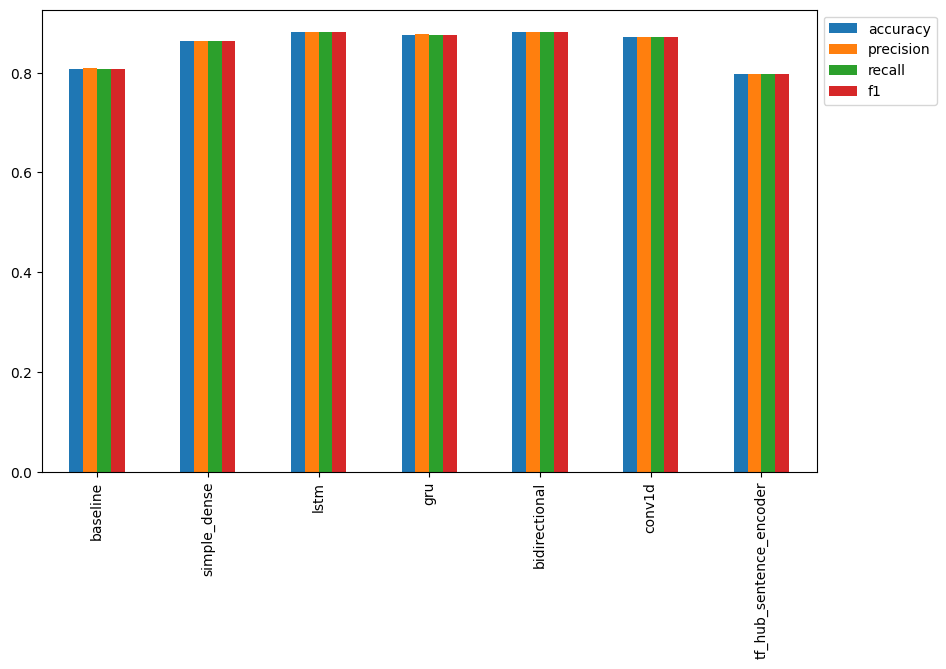

In [ ]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results})
all_model_results = all_model_results.transpose()
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot(kind="bar", figsize=(10, 6)).legend(bbox_to_anchor=(1.0, 1.0));

## Combine

In [ ]:
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1)
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3)

In [ ]:
ensemble_results = calculate_results(val_labels, combined_preds)
all_model_results.loc["ensemble_results"] = ensemble_results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
baseline,0.807481,0.809938,0.807481,0.806759
simple_dense,0.864334,0.864382,0.864334,0.864346
lstm,0.882479,0.882474,0.882479,0.882467
gru,0.875686,0.877087,0.875686,0.875440
bidirectional,0.882107,0.882193,0.882107,0.882121
conv1d,0.871220,0.871573,0.871220,0.871244
tf_hub_sentence_encoder,0.797060,0.797195,0.797060,0.797089
ensemble_results,88.638690,0.887021,0.886387,0.886406


## Sentiment

In [ ]:
df['sentiment'] = df['sentiment'].map({0.0:'Negative', 1.0:'Positive'})

In [ ]:
df.head()

,Unnamed: 0,text,sentiment
0,0,text,Negative
1,1,rising cases of covid does not alarm me rising...,Positive
2,2,please vote for chicagoindiaresolution marking...,Negative
3,3,wishing all of you eidaladha hazrat ibrahim as...,Positive
4,4,daily coronavirus cases in india top for first...,Positive


In [ ]:
X = list(map(clean_text, df['text']))

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y = le.fit_transform(df['sentiment'])

In [ ]:
from sklearn.model_selection import train_test_split
y = pd.get_dummies(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vocabulary_size = 5000
count_vector = CountVectorizer(max_features=vocabulary_size,
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x)
X_train = count_vector.fit_transform(X_train).toarray()

X_test = count_vector.transform(X_test).toarray()
y = pd.get_dummies(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer
X, tokenizer = tokenize_pad_sequences(df['text'])

In [ ]:
y = pd.get_dummies(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
import keras.backend as K

def f1_score(precision, recall):
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            160000    
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 25, 32)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 1

In [ ]:
import tensorflow as tf
model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
y_val.shape

(26866, 2)

In [ ]:
batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=4, verbose=1)

Epoch 1/4
1260/1260 [==============================] - 21s 17ms/step - loss: 0.0064 - accuracy: 0.9982 - val_loss: 0.3537 - val_accuracy: 0.9416
Epoch 2/4
1260/1260 [==============================] - 21s 16ms/step - loss: 0.0063 - accuracy: 0.9982 - val_loss: 0.2962 - val_accuracy: 0.9471
Epoch 3/4
1260/1260 [==============================] - 12s 10ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.2944 - val_accuracy: 0.9442
Epoch 4/4
1260/1260 [==============================] - 13s 10ms/step - loss: 0.0056 - accuracy: 0.9984 - val_loss: 0.3338 - val_accuracy: 0.9404


In [ ]:
sentiment_pred_probs = model.predict(X_test)
sentiment_preds = tf.squeeze(tf.round(sentiment_pred_probs))
sentiment_results = calculate_results(y_true=y_test,
                                    y_pred=sentiment_preds)
sentiment_results

840/840 [==============================] - 3s 3ms/step


{'accuracy': 93.8584083972307,
 'precision': 0.9394400018971124,
 'recall': 0.938584083972307,
 'f1': 0.9385803590736271}

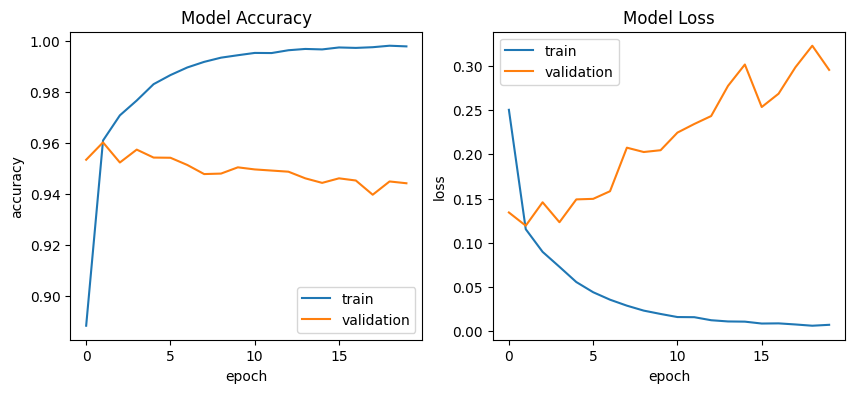

In [ ]:
def plot_training_hist(history):
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
plot_training_hist(history)

In [ ]:
def predict_class(text):
    sentiment_classes = ['Negative', 'Positive']
    max_len=50
    xt = tokenizer.texts_to_sequences(text)
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    yt = model.predict(xt).argmax(axis=1)
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [ ]:
predict_class(['"You are so ugly'])

1/1 [==============================] - 0s 161ms/step
The predicted sentiment is Negative


In [ ]:
predict_class(['I am slow'])

1/1 [==============================] - 0s 76ms/step
The predicted sentiment is Negative


In [ ]:
from keras.layers import BatchNormalization

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(2, activation='softmax'))

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=20, verbose=1,
                      callbacks=[early_stopping, reduce_lr])
